# Aufgabe 3 - Tiefe Einblicke ins Institut: Reloaded

Den Code immer nachvollziehbar kommentieren! Bitte beachtet, dass das Notebook von Anfang bis Ende ohne Fehler durchlaufen muss und dass die requirements.txt Datei aktualisiert wird. 

In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F  
import torchvision.transforms as T
import torch.optim as optim
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

## Teilaufgabe a): Trainings-, Test-und Validierungsdatenset

In [2]:
training_path_list = [[],[],[],[]]  # Gleiche Liste aus Aufgabe 2
test_path_list = [[], [], [], []]  # Gleiche Liste aus Aufgabe 2
validation_path_list = [[], [], [], []]  # ["./pfad/zu/bildZ.png","./pfad/zu/bildY.png",...]

def training_list():
    for i in range(15):
        training_path_list[0].append(f"./Bilder/Flur/Flur{i+1}.jpg")
    for i in range(15):
        training_path_list[1].append(f"./Bilder/Labor/Labor{i+1}.jpg")
    for i in range(15):
        training_path_list[2].append(f"./Bilder/Professorenbuero/Professorenbuero{i+1}.jpg")
    for i in range(15):
        training_path_list[3].append(f"./Bilder/Teekueche/Teekueche{i+1}.jpg")

def test_list():
    for i in range(5):
        test_path_list[0].append(f"./Bilder/Flur/Flur{i+16}.jpg")
    for i in range(5):
        test_path_list[1].append(f"./Bilder/Labor/Labor{i+16}.jpg")
    for i in range(5):
        test_path_list[2].append(f"./Bilder/Professorenbuero/Professorenbuero{i+16}.jpg")
    for i in range(5):
        test_path_list[3].append(f"./Bilder/Teekueche/Teekueche{i+16}.jpg")


def validations_list():
    for i in range(5):
        validation_path_list[0].append(f"./Bilder/Flur/Flur{i+21}.jpg")
    for i in range(5):
        validation_path_list[1].append(f"./Bilder/Labor/Labor{i+21}.jpg")
    for i in range(5):
        validation_path_list[2].append(f"./Bilder/Professorenbuero/Professorenbuero{i+21}.jpg")
    for i in range(5):
        validation_path_list[3].append(f"./Bilder/Teekueche/Teekueche{i+21}.jpg")


training_list()
test_list()
validations_list()
print("Trainingsdaten: " + str(training_path_list))
print("Testdaten: " + str(test_path_list))
print("Validierungsdaten: " + str(validation_path_list))

Trainingsdaten: [['./Bilder/Flur/Flur1.jpg', './Bilder/Flur/Flur2.jpg', './Bilder/Flur/Flur3.jpg', './Bilder/Flur/Flur4.jpg', './Bilder/Flur/Flur5.jpg', './Bilder/Flur/Flur6.jpg', './Bilder/Flur/Flur7.jpg', './Bilder/Flur/Flur8.jpg', './Bilder/Flur/Flur9.jpg', './Bilder/Flur/Flur10.jpg', './Bilder/Flur/Flur11.jpg', './Bilder/Flur/Flur12.jpg', './Bilder/Flur/Flur13.jpg', './Bilder/Flur/Flur14.jpg', './Bilder/Flur/Flur15.jpg'], ['./Bilder/Labor/Labor1.jpg', './Bilder/Labor/Labor2.jpg', './Bilder/Labor/Labor3.jpg', './Bilder/Labor/Labor4.jpg', './Bilder/Labor/Labor5.jpg', './Bilder/Labor/Labor6.jpg', './Bilder/Labor/Labor7.jpg', './Bilder/Labor/Labor8.jpg', './Bilder/Labor/Labor9.jpg', './Bilder/Labor/Labor10.jpg', './Bilder/Labor/Labor11.jpg', './Bilder/Labor/Labor12.jpg', './Bilder/Labor/Labor13.jpg', './Bilder/Labor/Labor14.jpg', './Bilder/Labor/Labor15.jpg'], ['./Bilder/Professorenbuero/Professorenbuero1.jpg', './Bilder/Professorenbuero/Professorenbuero2.jpg', './Bilder/Professorenbue

## Teilaufgabe b): CNN definieren und implementieren

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Nach 3x MaxPool (jeweils /2): 224 -> 112 -> 56 -> 28
        self.fc1 = nn.Linear(64 * 28 * 28, 128)  # 64 Kanäle, 28x28 Pixel
        self.fc2 = nn.Linear(128, 4)  # 4 Klassen

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

## Teilaufgabe c): Training und Test mit CNN

Datenset-Klasse um mit Pytorch Bilder zu laden. 

Input sind: 
- Liste mit Pfaden zu Bildern
- Liste mit dazugehörigen Labels (numerisch darstellen!) 
- Transformation der Bilder


In [4]:
from torch.utils.data import Dataset

class ROBDataset(Dataset):
    def __init__(self, img_path_list, img_labels, transform=None):
        # Pfade zu den Bildern als list
        self.img_path_list = img_path_list
        
        # Dazugehörige Labels zu den Bildern als list
        self.img_labels = img_labels
        
        # Transformations der Bilder
        self.transform = transform

    def __len__(self):
        return len(self.img_path_list)

    def __getitem__(self, idx):
        # Bild laden
        img_path = self.img_path_list[idx]
        image = read_image(img_path)
        
        # Label laden
        label = self.img_labels[idx]
        
        # Transformieren
        if self.transform:
            image = self.transform(image)
            
        return image.float(), int(label)
    

Trainingsiteration über alle Bilder.

Inputs sind:
- Pytorch dataloader Object über das iteriert wird
- bool do_backprob Parameter um Backpropagation durchzuführen oder nicht

In [5]:
# Iterating over the entire data set once
def run_iteration(dataloader, do_backprob=True):
    global net, optimizer, criterion
    loss_iter = []
    acc_iter = []
    for batch_x, batch_y in dataloader:
        # To device
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        y_predict = net(batch_x)
        loss = criterion(y_predict, batch_y)
        if do_backprob:
            loss.backward()
            optimizer.step()

        # statistics
        loss_iter.append(loss.detach().cpu().numpy())
        
        _, predicted = torch.max(torch.softmax(y_predict, dim=1),1)
        
        acc_iter.append(accuracy_score(batch_y.detach().cpu().numpy(), 
                                       predicted.detach().cpu().numpy()))
    
    return np.mean(loss_iter), np.mean(acc_iter)

Komplette Durchführung eines Trainings
Die Variablen y_train, y_val und y_test müssen noch gesetzt werden. Diese Listen beinhalten die entsprechenden Labels als numerische Darstellung.

Running on  cpu

Started Training
Epoch 1 from 100
	Train Loss	 1.7064265
	Train Acc.	 0.3489583333333333
	Val Loss	 1.2921903
	Val Acc.	 0.53125
Epoch 2 from 100
	Train Loss	 1.4097735
	Train Acc.	 0.3125
	Val Loss	 1.3422024
	Val Acc.	 0.4375
Epoch 3 from 100
	Train Loss	 1.3473252
	Train Acc.	 0.4635416666666667
	Val Loss	 1.3295767
	Val Acc.	 0.40625
Epoch 4 from 100
	Train Loss	 1.2586256
	Train Acc.	 0.5104166666666666
	Val Loss	 1.3625205
	Val Acc.	 0.25
Epoch 5 from 100
	Train Loss	 1.03191
	Train Acc.	 0.796875
	Val Loss	 1.6187768
	Val Acc.	 0.28125
Epoch 6 from 100
	Train Loss	 0.6445221
	Train Acc.	 0.828125
	Val Loss	 1.931526
	Val Acc.	 0.25
Epoch 7 from 100
	Train Loss	 0.3357805
	Train Acc.	 0.9010416666666666
	Val Loss	 2.111103
	Val Acc.	 0.375
Epoch 8 from 100
	Train Loss	 0.18034327
	Train Acc.	 0.9635416666666666
	Val Loss	 3.269043
	Val Acc.	 0.28125
Epoch 9 from 100
	Train Loss	 0.068812676
	Train Acc.	 0.96875
	Val Loss	 3.404541
	Val Acc.	 0.28125
Epoch 10 from

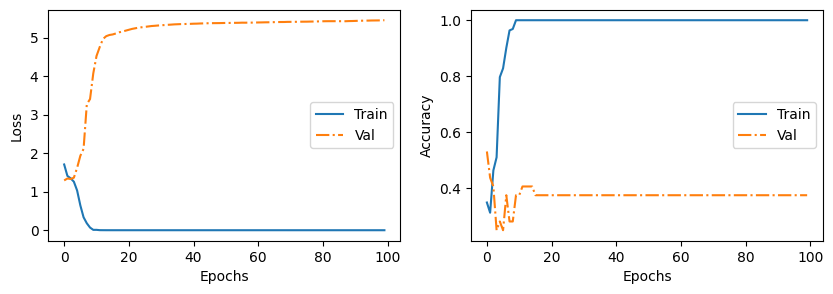

In [6]:
# Flache Listen für alle Bildpfade erzeugen
# => Vermeidung von Indexfehlern bei der Übergabe des Datasets an den Dataloader
flat_training_path_list = sum(training_path_list, [])
flat_validation_path_list = sum(validation_path_list, [])
flat_test_path_list = sum(test_path_list, [])


# Training settings - bei Bedarf anpassbar
max_epoch = 100
batch_size = 16
lr = 0.001

# Labeling der Trainingdaten flur, labor, professorenbuero, teekueche (0 = Flur, 1 = Labor, 2 = Professorenbuero, 3 = Teekeuche)
y_train = [0]*15 + [1]*15 + [2]*15 +[3]*15

# Labeling der Testdaten
y_test = [0]*5 + [1]*5 + [2]*5 +[3]*5

# Labeling der Validierungsdaten
y_val = [0]*5 + [1]*5 + [2]*5 + [3]*5



# Transformations for dataloader
t_train = T.Compose([T.ToPILImage(),
                   T.ToTensor(),
                   T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
t_val = T.Compose([T.ToPILImage(),
                   T.ToTensor(),
                   T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
t_test = T.Compose([T.ToPILImage(),
                   T.ToTensor(),
                   T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

# Where to do calculations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on ",device)


# Training Data, NOTE: y_train labels need to be set CHECK
# Übergabe des flachen Liste an dem Dataset
dataset_train = ROBDataset(flat_training_path_list, y_train, transform=t_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# Validation Data, NOTE: y_val labels need to be set CHECK
# Übergabe des flachen Liste an dem Dataset
dataset_val = ROBDataset(flat_validation_path_list, y_val, transform=t_train)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

# Test Data, NOTE: y_test labels need. to be set CHECK
# Übergabe des flachen Liste an dem Dataset
dataset_test = ROBDataset(flat_test_path_list, y_test,transform=t_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Network, optimizer and loss initialisation
net = Net()
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# Los geht's mit Training
print("\nStarted Training")
# Training loss and accuracy per epoch
train_loss_epoch = []
train_acc_epoch = []
# Validation loss and accuracy per epoch
val_loss_epoch = []
val_acc_epoch = []

for epoch in range(0,max_epoch):  # loop over the dataset multiple times
    print(f"Epoch {epoch+1} from {max_epoch}")
    
    ### TRAINING ###
    net.train()
    try:
        train_loss_iter, train_acc_iter = run_iteration(dataloader_train)
    except Exception as e:
        print(f"Fehler in run_iteration: {e}")
        print(f"dataloader_train Länge: {len(dataloader_train)}")
        break

    # Logging loss and accuarcy of training iteration
    train_loss_epoch.append(train_loss_iter)
    train_acc_epoch.append(train_acc_iter)
    print("\tTrain Loss\t",train_loss_iter)
    print("\tTrain Acc.\t",train_acc_iter)
    
    ### VALIDATION ###
    with torch.no_grad():  # No gradient calculation
        net.eval()
        val_loss_iter, val_acc_iter = run_iteration(dataloader_val,do_backprob=False)

        # Logging loss and accuarcy of validation iteration
        val_loss_epoch.append(val_loss_iter)
        val_acc_epoch.append(val_acc_iter)
        print("\tVal Loss\t",val_loss_iter)
        print("\tVal Acc.\t",val_acc_iter)

# Plotting results
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,3))
ax[0].plot(train_loss_epoch,label="Train")
ax[0].plot(val_loss_epoch,label="Val",linestyle="-.")
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend()

ax[1].plot(train_acc_epoch,label="Train")
ax[1].plot(val_acc_epoch,label="Val",linestyle="-.")
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].legend()
plt.savefig("loss_augmentation.png",format="png",bbox_inches="tight")
plt.show()


--- Evaluation ---


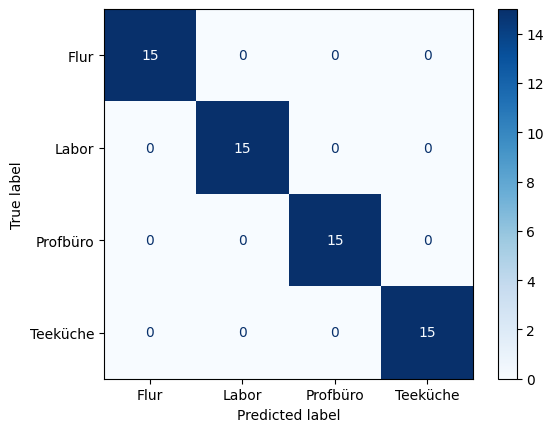

Train:	Accuracy: 1.000	F1: 1.000	Recall: 1.000	Precision: 1.000


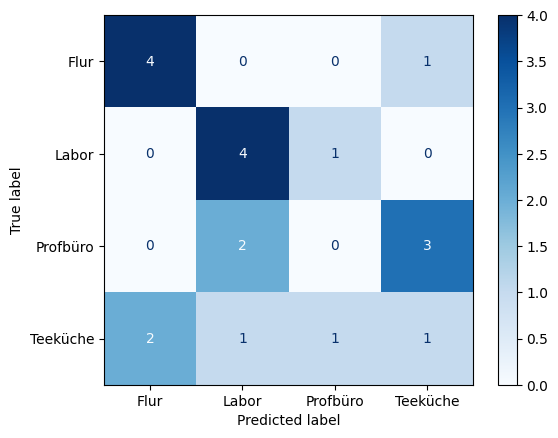

Validation:	Accuracy: 0.450	F1: 0.398	Recall: 0.450	Precision: 0.360


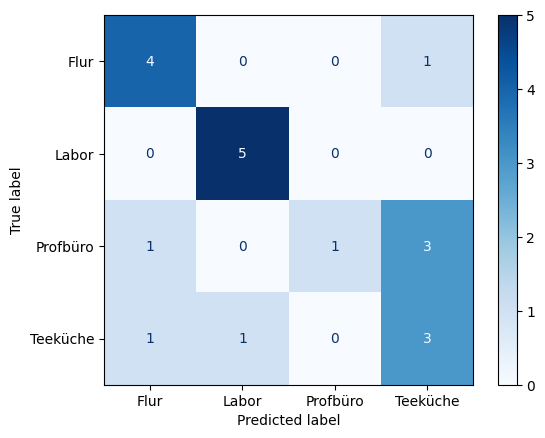

Test:	Accuracy: 0.650	F1: 0.617	Recall: 0.650	Precision: 0.732


In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Hilfsfunktion für Auswertung auf einem Datensatz
def evaluate_model(dataloader, net, device):
    net.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            outputs = net(batch_x)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Flur', 'Labor', 'Profbüro', 'Teeküche'])
    disp.plot(cmap='Blues')
    plt.show()
    return acc, f1, recall, precision

# Nach dem Training: Auswertung auf Trainings-, Validierungs- und Testset
print('--- Evaluation ---')
for name, loader in zip(['Train', 'Validation', 'Test'], [dataloader_train, dataloader_val, dataloader_test]):
    acc, f1, recall, precision = evaluate_model(loader, net, device)
    print(f'{name}:	Accuracy: {acc:.3f}\tF1: {f1:.3f}\tRecall: {recall:.3f}\tPrecision: {precision:.3f}')

## Teilaufgabe d): Augmentierung

Running on  cpu

Started Training
Epoch 1 from 100
	Train Loss	 1.5599499
	Train Acc.	 0.13541666666666666
	Val Loss	 1.31816
	Val Acc.	 0.5625
Epoch 2 from 100
	Train Loss	 1.4266295
	Train Acc.	 0.2604166666666667
	Val Loss	 1.3293805
	Val Acc.	 0.5625
Epoch 3 from 100
	Train Loss	 1.3674169
	Train Acc.	 0.2552083333333333
	Val Loss	 1.558589
	Val Acc.	 0.1875
Epoch 4 from 100
	Train Loss	 1.3102516
	Train Acc.	 0.42708333333333337
	Val Loss	 1.3919833
	Val Acc.	 0.25
Epoch 5 from 100
	Train Loss	 1.2297937
	Train Acc.	 0.5833333333333334
	Val Loss	 1.2984582
	Val Acc.	 0.46875
Epoch 6 from 100
	Train Loss	 1.0918273
	Train Acc.	 0.5104166666666666
	Val Loss	 1.4628353
	Val Acc.	 0.4375
Epoch 7 from 100
	Train Loss	 0.9360242
	Train Acc.	 0.59375
	Val Loss	 1.1261826
	Val Acc.	 0.46875
Epoch 8 from 100
	Train Loss	 0.83438134
	Train Acc.	 0.6666666666666666
	Val Loss	 1.8054875
	Val Acc.	 0.375
Epoch 9 from 100
	Train Loss	 0.6275947
	Train Acc.	 0.7708333333333334
	Val Loss	 2.34857

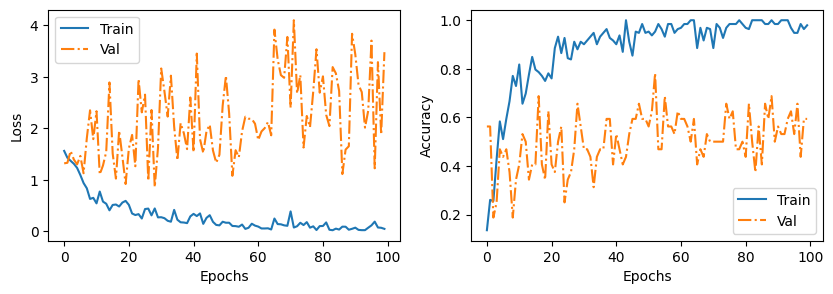

--- Evaluation ---


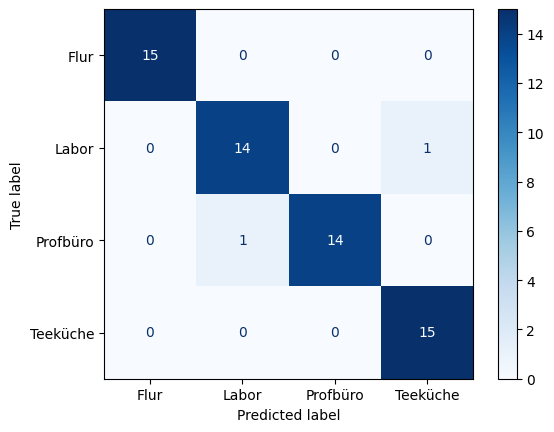

Train:	Accuracy: 0.967	F1: 0.967	Recall: 0.967	Precision: 0.968


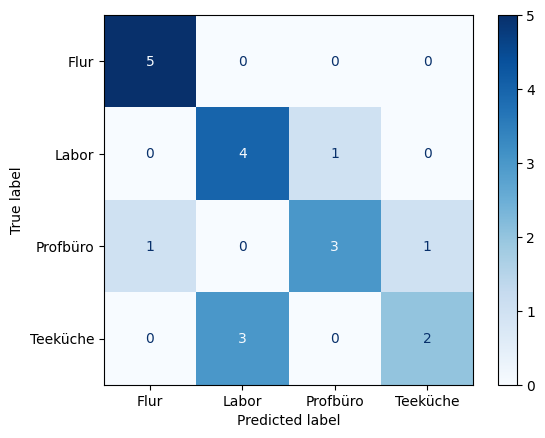

Validation:	Accuracy: 0.700	F1: 0.686	Recall: 0.700	Precision: 0.705


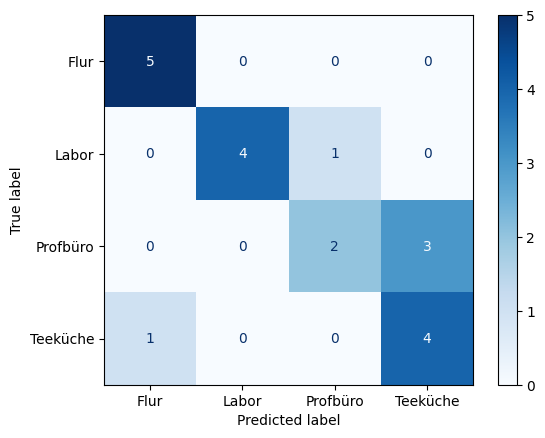

Test:	Accuracy: 0.750	F1: 0.741	Recall: 0.750	Precision: 0.768


In [8]:
flat_training_path_list = sum(training_path_list, [])
flat_validation_path_list = sum(validation_path_list, [])
flat_test_path_list = sum(test_path_list, [])


# Training settings - bei Bedarf anpassbar
max_epoch = 100
batch_size = 16
lr = 0.001

# Labeling der Trainingdaten flur, labor, professorenbuero, teekueche (0 = Flur, 1 = Labor, 2 = Professorenbuero, 3 = Teekeuche)
y_train = [0]*15 + [1]*15 + [2]*15 +[3]*15

# Labeling der Testdaten
y_test = [0]*5 + [1]*5 + [2]*5 +[3]*5

# Labeling der Validierungsdaten
y_val = [0]*5 + [1]*5 + [2]*5 + [3]*5



# Augmentierte Parameter für die Transformationen
t_train = T.Compose([
                    T.ToPILImage(),
                    T.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
                    T.RandomHorizontalFlip(p=0.5),
                    T.RandomRotation(15),
                    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
                    T.RandomGrayscale(p=0.1),
                    T.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
                    T.ToTensor(),
                    T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
t_val = T.Compose([T.ToPILImage(),
                   T.ToTensor(),
                   T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
t_test = T.Compose([T.ToPILImage(),
                   T.ToTensor(),
                   T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

# Where to do calculations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on ",device)


dataset_train = ROBDataset(flat_training_path_list, y_train, transform=t_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = ROBDataset(flat_validation_path_list, y_val, transform=t_train)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

dataset_test = ROBDataset(flat_test_path_list, y_test,transform=t_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Network, optimizer and loss initialisation
net = Net()
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# Los geht's mit Training
print("\nStarted Training")
# Training loss and accuracy per epoch
train_loss_epoch = []
train_acc_epoch = []
# Validation loss and accuracy per epoch
val_loss_epoch = []
val_acc_epoch = []

for epoch in range(0,max_epoch):  # loop over the dataset multiple times
    print(f"Epoch {epoch+1} from {max_epoch}")
    
    ### TRAINING ###
    net.train()
    try:
        train_loss_iter, train_acc_iter = run_iteration(dataloader_train)
    except Exception as e:
        print(f"Fehler in run_iteration: {e}")
        print(f"dataloader_train Länge: {len(dataloader_train)}")
        break

    # Logging loss and accuarcy of training iteration
    train_loss_epoch.append(train_loss_iter)
    train_acc_epoch.append(train_acc_iter)
    print("\tTrain Loss\t",train_loss_iter)
    print("\tTrain Acc.\t",train_acc_iter)
    
    ### VALIDATION ###
    with torch.no_grad():  # No gradient calculation
        net.eval()
        val_loss_iter, val_acc_iter = run_iteration(dataloader_val,do_backprob=False)

        # Logging loss and accuarcy of validation iteration
        val_loss_epoch.append(val_loss_iter)
        val_acc_epoch.append(val_acc_iter)
        print("\tVal Loss\t",val_loss_iter)
        print("\tVal Acc.\t",val_acc_iter)

# Plotting results
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,3))
ax[0].plot(train_loss_epoch,label="Train")
ax[0].plot(val_loss_epoch,label="Val",linestyle="-.")
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend()

ax[1].plot(train_acc_epoch,label="Train")
ax[1].plot(val_acc_epoch,label="Val",linestyle="-.")
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].legend()
plt.savefig("loss_augmentation.png",format="png",bbox_inches="tight")
plt.show()


# Evaluierung auf einem Datensatz
def evaluate_model(dataloader, net, device):
    net.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            outputs = net(batch_x)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Flur', 'Labor', 'Profbüro', 'Teeküche'])
    disp.plot(cmap='Blues')
    plt.show()
    return acc, f1, recall, precision


print('--- Evaluation ---')
for name, loader in zip(['Train', 'Validation', 'Test'], [dataloader_train, dataloader_val, dataloader_test]):
    acc, f1, recall, precision = evaluate_model(loader, net, device)
    print(f'{name}:	Accuracy: {acc:.3f}\tF1: {f1:.3f}\tRecall: {recall:.3f}\tPrecision: {precision:.3f}')

## Teilaufgabe e): Early Stopping

Epoch 1 from 100
	Train Loss	 0.019763978
	Train Acc.	 1.0
	Val Loss	 3.0062757
	Val Acc.	 0.46875
Epoch 2 from 100
	Train Loss	 0.094785795
	Train Acc.	 0.9791666666666666
	Val Loss	 3.0753124
	Val Acc.	 0.46875
EarlyStopping patience: 1/10
Epoch 3 from 100
	Train Loss	 0.209337
	Train Acc.	 0.9114583333333334
	Val Loss	 2.5215824
	Val Acc.	 0.59375
Epoch 4 from 100
	Train Loss	 0.12216643
	Train Acc.	 0.9375
	Val Loss	 1.514244
	Val Acc.	 0.53125
Epoch 5 from 100
	Train Loss	 0.044519674
	Train Acc.	 1.0
	Val Loss	 1.4713964
	Val Acc.	 0.59375
Epoch 6 from 100
	Train Loss	 0.13133782
	Train Acc.	 0.9375
	Val Loss	 2.4434075
	Val Acc.	 0.53125
EarlyStopping patience: 1/10
Epoch 7 from 100
	Train Loss	 0.1526624
	Train Acc.	 0.96875
	Val Loss	 1.3640497
	Val Acc.	 0.6875
Epoch 8 from 100
	Train Loss	 0.021579582
	Train Acc.	 1.0
	Val Loss	 2.607125
	Val Acc.	 0.625
EarlyStopping patience: 1/10
Epoch 9 from 100
	Train Loss	 0.06525127
	Train Acc.	 0.9635416666666666
	Val Loss	 2.9253333

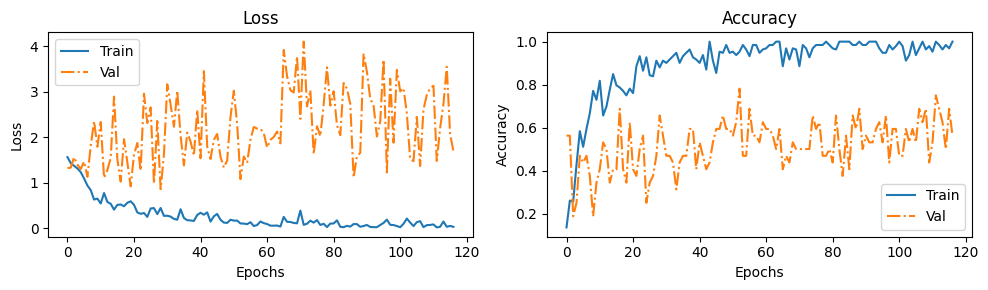

In [ ]:
# Early Stopping Parameter
early_stopping_patience = 10  # Anzahl Epochen ohne Verbesserung, bevor gestoppt wird
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

for epoch in range(0, max_epoch):
    print(f"Epoch {epoch+1} from {max_epoch}")
    net.train()
    try:
        train_loss_iter, train_acc_iter = run_iteration(dataloader_train)
    except Exception as e:
        print(f"Fehler in run_iteration: {e}")
        print(f"dataloader_train Länge: {len(dataloader_train)}")
        break
    train_loss_epoch.append(train_loss_iter)
    train_acc_epoch.append(train_acc_iter)
    print("\tTrain Loss\t", train_loss_iter)
    print("\tTrain Acc.\t", train_acc_iter)
    with torch.no_grad():
        net.eval()
        val_loss_iter, val_acc_iter = run_iteration(dataloader_val, do_backprob=False)
        val_loss_epoch.append(val_loss_iter)
        val_acc_epoch.append(val_acc_iter)
        print("\tVal Loss\t", val_loss_iter)
        print("\tVal Acc.\t", val_acc_iter)
    # Early Stopping Check
    if val_loss_iter < best_val_loss:
        best_val_loss = val_loss_iter
        patience_counter = 0
        best_model_state = net.state_dict()
    else:
        patience_counter += 1
        print(f"EarlyStopping patience: {patience_counter}/{early_stopping_patience}")
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping nach {epoch+1} Epochen!")
            break
# Nach dem Training bestes Modell laden
if best_model_state is not None:
    net.load_state_dict(best_model_state)
    print("Bestes Modell (mit niedrigstem Val-Loss) geladen.")

# Plotting Loss und Accuracy nach Early Stopping
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
ax[0].plot(train_loss_epoch, label="Train")
ax[0].plot(val_loss_epoch, label="Val", linestyle="-.")
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend()
ax[0].set_title('Loss')

ax[1].plot(train_acc_epoch, label="Train")
ax[1].plot(val_acc_epoch, label="Val", linestyle="-.")
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].legend()
ax[1].set_title('Accuracy')
plt.tight_layout()
plt.savefig("loss_earlystopping.png", format="png", bbox_inches="tight")
plt.show()

# Evaluierung auf einem Datensatz
def evaluate_model(dataloader, net, device):
    net.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            outputs = net(batch_x)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Flur', 'Labor', 'Profbüro', 'Teeküche'])
    disp.plot(cmap='Blues')
    plt.show()
    return acc, f1, recall, precision